# Data Preparation

We take Zeisel dataset as example. Zeisel dataset can be download from https://storage.googleapis.com/linnarsson-lab-www-blobs/blobs/cortex/expression_mRNA_17-Aug-2014.txt.
First we preprocess Zeisel dataset by filtering genes based on the number of cells and selecting high variable genes.

We also provide demo data as shown in ../demo_data/embedding/input and expected output as shown in ../demo_data/embedding/output 

In [2]:
import pandas as pd
import scanpy as sc
zeisel = pd.read_csv('../../scGRN/expression_mRNA_17-Aug-2014.txt',sep='\t',index_col=0)
data = zeisel.iloc[10:,1:].astype(float)
adata = sc.AnnData(data)
adata = adata.transpose()
sc.pp.filter_genes(adata,min_cells=30)
adata.var['std'] = adata.X.std(0)
adata.obs['label'] = list(zeisel.iloc[7])[1:]
Zeisel_dataset = adata[:,adata.var.sort_values('std',ascending=False).iloc[:1000].index]
sc.pp.log1p(Zeisel_dataset)


In [3]:
pd.DataFrame(Zeisel_dataset.X,index=list(Zeisel_dataset.obs_names),columns=list(Zeisel_dataset.var_names)).to_csv('../demo_data/embedding/input/Zeisel.csv')

# Run DeepSEM by using command 
"python main.py --data_file ../demo_data/embedding/input/Zeisel.csv --task embedding "

In [ ]:
! nohup python main.py --data_file ../demo_data/embedding/input/Zeisel.csv --task embedding &

## UMAP Plot

In [4]:
output = sc.read_h5ad('../demo_data/embedding/output/DeepSEM.h5ad')
sc.pp.neighbors(output,n_neighbors=30)
maxn = 2
minn= 0
x = 1
sc.tl.louvain(output,resolution=x,random_state=0)
N =len(set(output.obs['label']))
while len(set(output.obs['louvain'])) !=N:
    if   len(set(output.obs['louvain'])) < N:
            minn = x
            x = (maxn+x) /2
    if   len(set(output.obs['louvain'])) > N:
            maxn= x
            x = (minn+x) /2
    print(x,maxn,minn)
    sc.tl.louvain(output,resolution=x,random_state=0)

/sda4/shuhantao/anaconda2/envs/geometric/lib/python3.7/site-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9002. The TBB threading layer is disabled.
  warnings.warn(problem)


0.5 1 0


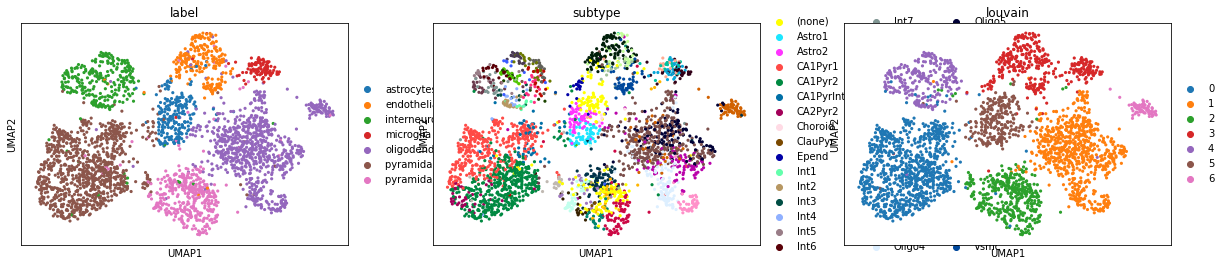

In [5]:
sc.tl.umap(output)
sc.pl.umap(output,color=['label','subtype','louvain'])

/sda4/shuhantao/anaconda2/envs/geometric/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


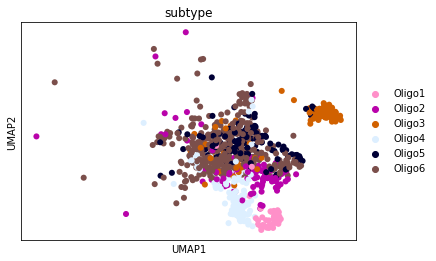

In [6]:
sc.pl.umap(output[output.obs['label']=='oligodendrocytes'],color='subtype')

## Cluster performance

In [8]:
from sklearn.metrics import adjusted_rand_score,adjusted_mutual_info_score
print(adjusted_rand_score(output.obs['label'],output.obs['louvain']),adjusted_mutual_info_score(output.obs['label'],output.obs['louvain']))

0.8316068843809352 0.7938286768739853
